# Naïve Bayes Classification TestBed
- *Author*: Juan Cabanela
- *Start Date*: November 15, 2021

### Requirements

Requires the following python libraries:
- pandas
- numpy
- scikit-learn (sklearn)

This notebook should only be executed using the cleaned version of the FakeNewsCorpus that has been "chunked" into smaller portions with the context preserved (so the punctuation has NOT be removed), mostly because that is the way the data will be loaded.

The `fullcontext_dir` defined at the end of the first block of code is where the notebook will look for the cleaned and chunked FaceNewsCorpus files (I defaulted to `./FakeNewsCorpus/fullcontextnews_chunked/`).

I am tokenizing the content text of the FakeNewsCorpus using the Scikit-Learn TF-IDF tokenizer. This is followed by an attempt to implement a series of Naïve Bayes classifiers that are trained on each of the 11 journalistic practices that have been categorized.

### History
- **November 15, 2021**: First version of this code.  Pulled much of it from the older ProjectDataTokenization notebook. Added TF-IDF tokenization.
- **November 18, 2021**: Added functioning Naïve Bayes classifier for classifying content as 'rumor' class was created and metrics output.
- **November 19, 2021**: Realized I could just pass the tokenized content directly to train_test_split() which avoids having to run the tokenizer on each training/testing set before processing.  This will make the process MUCH faster since tokenizing is the slowest part of the processing right now.  I also added a k-fold cross-validation sequence to obtain some statistics on the classifier accuracy.
- **November 20, 2021**: Added processing of all journalistic practice classes and storing of that information into a pickle file.  The classifier is NOT that great, not really surprising with Naïve Bayes, but still.  A reminder that
  - `accuracy` is the fraction of correctly identified (as positive or negative).
  - `recall` is the fraction of all true positives that are correctly identified and
  -  `precision` is the fraction of all positives that are true positives.

          category  	N_pos  	N_neg  	accuracy    	precision   	recall      	f1
          rumor     	 307317	1239893	0.860(0.011)	0.779(0.070)	0.419(0.055)	0.541(0.046)
          hate      	  37156	1510054	0.976(0.001)	0.528(0.152)	0.070(0.016)	0.124(0.027)
          unreliable	 110846	1436364	0.934(0.006)	0.779(0.085)	0.112(0.108)	0.179(0.150)
          conspiracy	 388930	1158280	0.824(0.014)	0.772(0.091)	0.445(0.036)	0.560(0.017)
          clickbait 	 260502	1286708	0.854(0.016)	0.623(0.087)	0.368(0.058)	0.458(0.055)
          satire    	  24156	1523054	0.985(0.001)	0.718(0.165)	0.103(0.068)	0.171(0.105)
          fake      	 251905	1295305	0.877(0.005)	0.852(0.077)	0.309(0.073)	0.444(0.065)
          reliable  	 384020	1163190	0.854(0.043)	0.753(0.094)	0.596(0.184)	0.654(0.151)
          bias      	 341300	1205910	0.817(0.015)	0.666(0.072)	0.357(0.055)	0.460(0.045)
          political 	 344186	1203024	0.834(0.042)	0.892(0.050)	0.284(0.208)	0.393(0.234)
          junksci   	  56472	1490738	0.966(0.003)	0.554(0.086)	0.282(0.063)	0.372(0.069)
- **November 22, 2021** Using the `ComplementNB()` which implements the version of MultinomialNB better designed for unbalanced datasets produced much better recall results although the precision and accuracy both drop (suggesting many more incorrect identifications and more false positives)!

          category  	N_pos  	N_neg  	accuracy    	precision   	recall      	f1
          rumor     	 307443	1239767	0.734(0.057)	0.421(0.064)	0.799(0.044)	0.548(0.057)
          hate      	  36819	1510391	0.680(0.105)	0.064(0.017)	0.817(0.090)	0.118(0.029)
          unreliable	 110797	1436413	0.652(0.066)	0.139(0.017)	0.715(0.068)	0.231(0.020)
          conspiracy	 389315	1157895	0.754(0.064)	0.521(0.081)	0.785(0.022)	0.622(0.056)
          clickbait 	 260270	1286940	0.686(0.060)	0.331(0.053)	0.787(0.035)	0.463(0.049)
          satire    	  24429	1522781	0.740(0.080)	0.047(0.013)	0.740(0.076)	0.088(0.024)
          fake      	 252193	1295017	0.787(0.029)	0.415(0.041)	0.697(0.030)	0.518(0.026)
          reliable  	 383462	1163748	0.776(0.045)	0.534(0.073)	0.830(0.148)	0.645(0.083)
          bias      	 340958	1206252	0.703(0.054)	0.415(0.049)	0.758(0.030)	0.533(0.037)
          political 	 343329	1203881	0.816(0.023)	0.607(0.053)	0.480(0.211)	0.513(0.133)
          junksci   	  55835	1491375	0.833(0.033)	0.153(0.034)	0.754(0.055)	0.253(0.046)

- **November 24, 2021** Discovered a few rows of the datafiles have 'NaN' in the `1st_type`.  I had to go back to the ProjectDataCleaning notebook and fix it.  Working on implementing a multiclass classifier including output of metrics and K-Fold cross-validation. Also implemented stratified dataset selection to have similar distribution of labels in each set and computed average metrics across the K-Folds.
- **November 26, 2021** Added a `MultinomialNB()` version of the multiclass classifier to compare to the `ComplementNB()` version previously developed.  Also added dumping of classification metrics galore to the multiclass classifiers.




In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import pickle
import time
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, naive_bayes, metrics
from sklearn.model_selection import cross_validate, StratifiedKFold

##
## Custom functions
##

def full_testing_report(test_Y, predicted_Y, classifier_label):
    # Get the training classification report and confusion matrix
    report = metrics.classification_report(test_Y, predicted_Y,
                                        target_names=['Positive', 'Negative'])
    conf_matrix = metrics.confusion_matrix(test_Y, predicted_Y)

    if (DEBUG):
        print(f"confusion matrix for {classifier_label}:")
        print(conf_matrix)

    tn, fp, fn, tp = conf_matrix.ravel()
    conf_matrix_report(tn, fp, fn, tp, classifier_label)
    print(f"\nclassification report for {classifier_label}:")
    print(report)


# Print out report based on confusion matrix
def conf_matrix_report(tn, fp, fn, tp, classifier_label):
    # Do some manual computations
    p = tp + fn  # Positives
    n = fp + tn  # Negatives

    print(f"Classification Summary for {classifier_label}:")
    print(f"\tClassed as positive: {p:07d}")
    print(f"\tClassed as negative: {n:07d}\n")

    print(f"Confusion Matrix for {jour_prac}:")
    print(" Predicted    Positive      Negative")
    print("Actual")
    print(f"Positive    {tp:07d}(TP)   {fn:07d}(FN)   {p:07d}(P)")
    print(f"Negative    {fp:07d}(FP)   {tn:07d}(TN)   {n:07d}(N)\n")

    accuracy = (tp + tn) / (p + n)
    err_rate = (fp + fn) / (p + n)
    precision = tp / (tp + fp)
    recall = tp / p
    specificity = tn / n
    Fscore = (2 * precision * recall) / (precision + recall)

    print(f"  Accuracy (TP+TN)/P+N =\t{accuracy:0.5f}")
    print(f"Error Rate (FP+FN)/P+N =\t{err_rate:0.5f}")
    print(f"  Precision TP/(TP+FP) =\t{precision:0.5f}")
    print(f"           Recall TP/P =\t{recall:0.5f}")
    print(f"      Specificity TN/N =\t{specificity:0.5f}")
    print(f"               F-Score =\t{Fscore:0.5f}")


# kfold_summary turns the scores directionary created by cross_validate and
# turns it into human readable information.
# Note: This assumes 'estimator' is returned and uses that as a blank column.
def kfold_summary(scores, verbose=False):
    keys = sorted(scores.keys())
    nkeys = len(keys)

    # Print all the data for each run of the k-fold cross-validation
    if (verbose):
        for key in keys:
                if (key != "estimator"):
                        print(f"{key:15s} ", end="")
                else:
                        print(f"                ", end="")
        print("")

        if (DEBUG):
            for i in range(len(scores[keys[0]])):
                for key in keys:
                    if (key != "estimator"):
                        print(f"{scores[key][i]:15.3f} ", end="")
                    else:
                        print(f"{' ':10s}", end="")
                print("")

    # Dictionaries for statistics
    avgs = {}
    stdev = {}

    for key in keys:
        if (key != "estimator"):
            newkey = "avg_"+key
            avgs[newkey] = np.average(scores[key])
            if (verbose):
                print(f"{avgs[newkey]:15.3f} ", end="")
        else:
            if (verbose):
                print(f"{'Mean:':8s}", end="")
    if (verbose):
        print("")

    for key in keys:
        if (key != "estimator"):
            newkey = "stdev_"+key
            stdev[newkey] = np.std(scores[key])
            if (verbose):
                print(f"{stdev[newkey]:15.3f} ", end="")
        else:
            if (verbose):
                print(f"{'Std Dev:':8s}", end="")
    if (verbose):
        print("")

    return(avgs, stdev)


##
## Define constants
##
DEBUG = False

# Directory containing chunked data
data_dir = "../FakeNewsCorpus/"
fullcontext_dir = f"{data_dir}fullcontextnews_chunked/"
var_dir = "../Variables/"


## Loading the chunked data files

Read the files which have already been cleaned but had their context preserved [so no stop words were removed and punctuation is intact] and build a single dataframe containing the entire cleaned dataset. It takes about 50sec to load all the data into memory. The full dataset now occupies about 5.5GB of memory unpacked.

In [9]:
# Set up path to chunked CSV files
chunked_path = pathlib.Path(fullcontext_dir)

# Set up path to pickle file
pickle_file = f"{data_dir}fullcontext_df.p"
pickle_path = pathlib.Path(pickle_file)

# If pickle file exists, avoid reprocessing and just load it
if (pickle_path.is_file()):
    print(f"Loading previously pickled fullcontext_df (about {pickle_path.stat().st_size/1024**3:0.2f} GB)")
    fullcontext_df = pickle.load( open( pickle_file, "rb" ) )  # Reading pickles should be cross-platform

    # Get all the categories as a list
    rawcategories = np.array(fullcontext_df["1st_type"].unique()).astype('str')
    categories = rawcategories[rawcategories != 'nan'].tolist()
else:
    # Create master dataframe
    fullcontext_df = pd.DataFrame(columns=["title", "content", "1st_type" , "2nd_type", "3rd_type"])

    # Iterate through chunked csv files alphabetically
    n_tot = 0

    print("Loading records: ")
    for i, fname in enumerate(sorted(chunked_path.iterdir())):
        if ".csv" in str(fname):
            print(f"   {fname.name}: ", end="")
            chunked_df = pd.read_csv(fname, dtype={'domain': str, 'title': str, 'content': str, '1st_type': str, '2nd_type': str, '3rd_type': str})

            n_tot = n_tot + chunked_df.shape[0]
            fullcontext_df = fullcontext_df.append(chunked_df, ignore_index=True)
            print(f" {chunked_df.shape[0]} entries loaded.")


    # Get all the categories as a list
    rawcategories = np.array(fullcontext_df["1st_type"].unique()).astype('str')
    categories = rawcategories[rawcategories != 'nan'].tolist()

    # Collect 1st_type counts
    summary = fullcontext_df["1st_type"].value_counts()

    # Add a column for each category, flagging the entry as an example, collect stats
    for cat in categories:
        fullcontext_df[cat] = (fullcontext_df['1st_type'] == cat) | (fullcontext_df['2nd_type']  == cat) | (fullcontext_df['3rd_type']  == cat)
        print(f"- '{cat}': {len(fullcontext_df[fullcontext_df[cat]])} total articles (only {summary[cat]} as 1st_type).")

    # Pickle the data
    print(f"Creating {pickle_file} ... ")
    pickle.dump( fullcontext_df, open(pickle_file, "wb" ) )

print(f"\n{fullcontext_df.shape[0]} entries loaded into fullcontext_df which is occupying {fullcontext_df.memory_usage(deep=True).sum()/1024**3:0.3f} GB of memory.")
print(f"- Classifications included for {len(categories)} classes of journalistic practices.")

Loading previously pickled fullcontext_df (about 4.66 GB)

7687298 entries loaded into fullcontext_df which is occupying 10.760 GB of memory.
- Classifications included for 11 classes of journalistic practices.


## Implementing TF-IDF vectorizer

Here we implement a TD-IDF vectorizer taken from Scikit-Learn and then save the resulting sparse array into a pickle file.  The idea is it takes about 13 minutes to run this, no need to needlessly run this.

The fitting and transform (`.fit_transform()`) of the data seems to take about 13 minutes, but `.fit()` followed by `.transform()` seems to take at least 13 minutes for each **each** command, not saving any time.  I am trying to rework the code to only have to do the tokenizing once and then save the results to disk so training/testing sets can be constructed quickly without requiring re-tokenizing of the data.

In [10]:
# Trying to get TF-IDF vectorizer to work on the fullcontext_df

# Create variables directory if needed
try:
    pathlib.Path(var_dir).mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"Variable storage directory {var_dir} is already there")
else:
    print(f"Variable storage directory {var_dir} was created")

# Set up path to pickle file
vectorizer_pickle_file = f"{var_dir}fullcontext_vectorizer.p"
tokenized_pickle_file = f"{var_dir}fullcontext_tokenized.p"
vectorizer_pickle_path = pathlib.Path(vectorizer_pickle_file)
tokenized_pickle_path = pathlib.Path(tokenized_pickle_file)
# If pickle files exist, avoid reprocessing and just load them
if (vectorizer_pickle_path.is_file() & tokenized_pickle_path.is_file() ):
    print(f"Loading previously pickled vectorizer (about {vectorizer_pickle_path.stat().st_size/1024**3:0.2f} GB)")
    vectorizer = pickle.load( open( vectorizer_pickle_file, "rb" ) )
    print(f"Loading previously pickled tokenized_corpus (about {tokenized_pickle_path.stat().st_size/1024**3:0.2f} GB)")
    tokenized_content = pickle.load( open( tokenized_pickle_file, "rb" ) )
else:
    print("Building new vectorizer and tokenized content...")

    # To prevent crashing out when processing, convert the Pandas column
    # of data into strings line by line.  Otherwise, when running the TfidfVectorizer
    # you will get the following error:
    # ValueError: np.nan is an invalid document, expected byte or unicode string.
    # unless I apply that string conversion to the column.
    corpus = fullcontext_df['content'].apply(lambda x: np.str_(x))

    # Now construct the vectorizer
    vectorizer = TfidfVectorizer(encoding='utf-8', decode_error='replace', strip_accents='ascii', stop_words='english', max_features=10000)

    # Apply the tokenizer (takes about 11-13 minutes to run)
    tokenized_content = vectorizer.fit_transform(corpus)

    # Pickle the data
    print(f"Creating {vectorizer_pickle_file} ... ")
    pickle.dump( vectorizer, open(vectorizer_pickle_file, "wb" ) )
    print(f"Creating {tokenized_pickle_file} ... ")
    pickle.dump( tokenized_content, open(tokenized_pickle_file, "wb" ) )

Variable storage directory ../Variables/ is already there
Loading previously pickled vectorizer (about 0.02 GB)
Loading previously pickled tokenized_corpus (about 3.80 GB)


In [11]:
if (DEBUG):
    # Report some stats on the TF-IDF runs
    print(f"get_feature_names_out: {vectorizer.get_feature_names_out()}")
    # Show vocabulary
    print(f"vocabulary_: {vectorizer.vocabulary_}")
    # Show additional stop words
    print(f"stop_words_: {vectorizer.stop_words_}")

# Implementation of Testbed Naïve Bayes Classifier (Binary Version)

I am following some of the approach laid out in [this article from the Medium website](https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34) for attemptin to set up a Naïve Bayes textual classifier. This will eventually need to be done one journalistic problem class at a time.

In [12]:
# This sets up the Multinomial Naive Bayes classifier, one of the styles of classifiers typically
# used with text classification problems.
#  https://scikit-learn.org/stable/modules/naive_bayes.html

# Set up path to pickle file
clfnet_pickle_file = f"{var_dir}MultinomialNB_network.p"
clfnet_pickle_path = pathlib.Path(clfnet_pickle_file)

# If pickle file exists, avoid reprocessing and just load them
if (clfnet_pickle_path.is_file()):
    print(f"Loading previously-built MultinomialNB classifier network (about {clfnet_pickle_path.stat().st_size/1024**2:0.2f} MB)")
    clf_network = pickle.load( open( clfnet_pickle_file, "rb" ) )
else:
    # Prepare dictionaries to store all the classifiers
    clf_network = {}

    # Track time for building of all the classifiers
    network_start_time = time.perf_counter()
    print(f"Constructing MultinomialNB classifier network: ")

    # Loop through all the journalistic practics and build the classifiers
    for jour_prac in categories:
        # Create blank dictionary
        this_entry = {}

        # Break up ENTIRE dataset into training and testing data (reserving 20% for testing).
        # Use the tokenized content so we can avoid having to re-tokenize the data each new pass through.
        print(f" - Constructing, training and testing Naïve Bayes classifier on test data on '{jour_prac}' class... ")
        Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y = model_selection.train_test_split(tokenized_content,fullcontext_df[jour_prac],test_size=0.2)

        # # The scikit-learn documentation notes that "Some classification problems can exhibit a large imbalance in
        # # the distribution of the target classes: for instance there could be several times more negative samples
        # # than positive samples. In such cases it is recommended to use stratified sampling".  This would be useful
        # # if I was checking multiple classes, not useful for Naïve Bayes.  Keeping this here as notes in case someone
        # # is grabbing testing/training data for multi-class classifier.
        # spliter = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        # for train_index, test_index in spliter.split(fullcontext_df, fullcontext_df['reliable']):
        #     strat_train_set = fullcontext_df.loc[train_index]
        #     strat_test_set = fullcontext_df.loc[test_index]
        # Train_X = strat_train_set['content']
        # Train_Y = strat_train_set['reliable']
        # Test_X = strat_test_set['content']
        # Test_Y = strat_test_set['reliable']

        # Implement Multinomial Naïve Bayes training for this dataset (including timing of the training)
        # Problem, currently returns all 'false' in fitting.
        start_time = time.perf_counter()
        clf = naive_bayes.MultinomialNB()
        clf.fit(Train_X_Tfidf, Train_Y)
        end_time = time.perf_counter()

        # Save the trained classifier
        this_entry["clf"] = clf

        if (DEBUG):
            print(f"clf.classes_: {clf.classes_}")
            print(f"clf.feature_count_: {clf.feature_count_}")

        # predict the labels on validation dataset
        predictions_NB = clf.predict(Test_X_Tfidf)
        print(f"   - {end_time - start_time:0.2f} seconds to fit and test Naïve Bayes classifier on '{jour_prac}' class.")

        # Report on the testing
        if (DEBUG):
            full_testing_report(Test_Y, predictions_NB, jour_prac)

        # Get confusion matrix on the model
        tn, fp, fn, tp = metrics.confusion_matrix(Test_Y, predictions_NB).ravel()
        conf_mat = {"TN": tn, "FP": fp, "FN": fn, "TP": tp}

        # Implement k-fold cross-validation to get a better handle on classfier accuracy.
        # Report on the various 'scoring' statistics.  cv=5 indicates we are doing k=5 cross-validations.
        start_time = time.perf_counter()
        scores = cross_validate(clf, tokenized_content,fullcontext_df[jour_prac], scoring={'accuracy','precision','recall', 'f1'},
                                cv=5, return_estimator=True)
        end_time = time.perf_counter()
        print(f"   - {end_time - start_time:0.2f} seconds to perform k-fold cross-validation on '{jour_prac}' class")

        # Provide kfold_summary
        (avgs, stdev) = kfold_summary(scores)

        # Merge various dictionaries into one record for this classifier
        this_entry = dict(chain.from_iterable(d.items() for d in (this_entry, conf_mat, avgs, stdev)))

        # store trained classifier and its stats in a dictionary
        clf_network[jour_prac] = this_entry

    # End of network time
    network_end_time = time.perf_counter()
    print(f"Entire classifier network took {network_end_time - network_start_time:0.2f} seconds to build.")

    # Pickle the data
    print(f"Creating {clfnet_pickle_file} ... ")
    pickle.dump(clf_network, open(clfnet_pickle_file, "wb" ) )


# Construct table of statistics describing classifier network
print(f"{'category':10s}\t{'N_pos':7s}\t{'N_neg':7s}\t{'accuracy':12s}\t{'precision':12s}\t{'recall':12s}\t{'f1':12s}")
for cat in clf_network:
    # Format statistics
    actual_pos = clf_network[cat]['TP']+clf_network[cat]['FN']
    actual_neg = clf_network[cat]['TN']+clf_network[cat]['FP']
    this_accuracy = f"{clf_network[cat]['avg_test_accuracy']:05.3f}({clf_network[cat]['stdev_test_accuracy']:05.3f})"
    this_precision = f"{clf_network[cat]['avg_test_precision']:05.3f}({clf_network[cat]['stdev_test_precision']:05.3f})"
    this_recall = f"{clf_network[cat]['avg_test_recall']:05.3f}({clf_network[cat]['stdev_test_recall']:05.3f})"
    this_f1 = f"{clf_network[cat]['avg_test_f1']:05.3f}({clf_network[cat]['stdev_test_f1']:05.3f})"

    # Print statistics
    print(f"{cat:10s}\t{actual_pos:7d}\t{actual_neg:7d}\t{this_accuracy}\t{this_precision}\t{this_recall}\t{this_f1}")




Loading previously-built MultinomialNB classifier network (about 3.37 MB)
category  	N_pos  	N_neg  	accuracy    	precision   	recall      	f1          
rumor     	 307705	1229755	0.859(0.012)	0.775(0.076)	0.423(0.056)	0.543(0.046)
hate      	  37235	1500225	0.976(0.001)	0.528(0.144)	0.070(0.016)	0.123(0.028)
unreliable	 111298	1426162	0.933(0.006)	0.784(0.079)	0.112(0.109)	0.178(0.150)
conspiracy	 388180	1149280	0.823(0.014)	0.770(0.093)	0.449(0.037)	0.562(0.016)
clickbait 	 260719	1276741	0.854(0.016)	0.625(0.087)	0.370(0.057)	0.460(0.053)
satire    	  24133	1513327	0.985(0.001)	0.721(0.162)	0.103(0.068)	0.171(0.104)
fake      	 252494	1284966	0.876(0.005)	0.852(0.078)	0.310(0.073)	0.445(0.065)
reliable  	 384354	1153106	0.854(0.042)	0.754(0.090)	0.600(0.184)	0.657(0.150)
bias      	 341004	1196456	0.816(0.014)	0.667(0.074)	0.356(0.055)	0.460(0.046)
political 	 344110	1193350	0.834(0.043)	0.895(0.046)	0.284(0.207)	0.393(0.234)
junksci   	  57370	1480090	0.967(0.003)	0.600(0.069)	0.30

In [13]:
# This sets up the Complement Naive Bayes classifier, one of the styles of classifiers typically
# used with text classification problems.  This algorithm uses a variant of Multinomial Naive Bayes that
# is designed (see Rennie et al. 2003) to work better with unbalanced datasets, so I want to see how it
# handles our FakeNewsCorpus which has only 2% positive examples in some cases.
#  https://scikit-learn.org/stable/modules/naive_bayes.html

# Set up path to pickle file
clfnet_pickle_file = f"{var_dir}ComplementNB_network.p"
clfnet_pickle_path = pathlib.Path(clfnet_pickle_file)

# If pickle file exists, avoid reprocessing and just load them
if (clfnet_pickle_path.is_file()):
    print(f"Loading previously-built ComplementNB classifier network (about {clfnet_pickle_path.stat().st_size/1024**2:0.2f} MB)")
    clf_network = pickle.load( open( clfnet_pickle_file, "rb" ) )
else:
    # Prepare dictionaries to store all the classifiers
    clf_network = {}

    # Track time for building of all the classifiers
    network_start_time = time.perf_counter()
    print(f"Constructing ComplementNB classifier network: ")

    # Loop through all the journalistic practics and build the classifiers
    for jour_prac in categories:
        # Create blank dictionary
        this_entry = {}

        # Break up ENTIRE dataset into training and testing data (reserving 20% for testing).
        # Use the tokenized content so we can avoid having to re-tokenize the data each new pass through.
        print(f" - Constructing, training and testing Naïve Bayes classifier on test data on '{jour_prac}' class... ")
        Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y = model_selection.train_test_split(tokenized_content,fullcontext_df[jour_prac],test_size=0.2)

        # Implement Complement Naïve Bayes training for this dataset (including timing of the training)
        # Problem, currently returns all 'false' in fitting.
        start_time = time.perf_counter()
        clf = naive_bayes.ComplementNB()
        clf.fit(Train_X_Tfidf, Train_Y)
        end_time = time.perf_counter()

        # Save the trained classifier
        this_entry["clf"] = clf

        if (DEBUG):
            print(f"clf.classes_: {clf.classes_}")
            print(f"clf.feature_count_: {clf.feature_count_}")

        # predict the labels on validation dataset
        predictions_NB = clf.predict(Test_X_Tfidf)
        print(f"   - {end_time - start_time:0.2f} seconds to fit and test Naïve Bayes classifier on '{jour_prac}' class.")

        # Report on the testing
        if (DEBUG):
            full_testing_report(Test_Y, predictions_NB, jour_prac)

        # Get confusion matrix on the model
        tn, fp, fn, tp = metrics.confusion_matrix(Test_Y, predictions_NB).ravel()
        conf_mat = {"TN": tn, "FP": fp, "FN": fn, "TP": tp}

        # Implement k-fold cross-validation to get a better handle on classfier accuracy.
        # Report on the various 'scoring' statistics.  cv=5 indicates we are doing k=5 cross-validations.
        start_time = time.perf_counter()
        scores = cross_validate(clf, tokenized_content,fullcontext_df[jour_prac], scoring={'accuracy','precision','recall', 'f1'},
                                cv=5, return_estimator=True)
        end_time = time.perf_counter()
        print(f"   - {end_time - start_time:0.2f} seconds to perform k-fold cross-validation on '{jour_prac}' class")

        # Provide kfold_summary
        (avgs, stdev) = kfold_summary(scores)

        # Merge various dictionaries into one record for this classifier
        this_entry = dict(chain.from_iterable(d.items() for d in (this_entry, conf_mat, avgs, stdev)))

        # store trained classifier and its stats in a dictionary
        clf_network[jour_prac] = this_entry

    # End of network time
    network_end_time = time.perf_counter()
    print(f"Entire classifier network took {network_end_time - network_start_time:0.2f} seconds to build.")

    # Pickle the classifier network information
    print(f"Creating {clfnet_pickle_file} ... ")
    pickle.dump(clf_network, open(clfnet_pickle_file, "wb" ) )


# Construct table of statistics describing classifier network
print(f"{'category':10s}\t{'N_pos':7s}\t{'N_neg':7s}\t{'accuracy':12s}\t{'precision':12s}\t{'recall':12s}\t{'f1':12s}")
for cat in clf_network:
    # Format statistics
    actual_pos = clf_network[cat]['TP']+clf_network[cat]['FN']
    actual_neg = clf_network[cat]['TN']+clf_network[cat]['FP']
    this_accuracy = f"{clf_network[cat]['avg_test_accuracy']:05.3f}({clf_network[cat]['stdev_test_accuracy']:05.3f})"
    this_precision = f"{clf_network[cat]['avg_test_precision']:05.3f}({clf_network[cat]['stdev_test_precision']:05.3f})"
    this_recall = f"{clf_network[cat]['avg_test_recall']:05.3f}({clf_network[cat]['stdev_test_recall']:05.3f})"
    this_f1 = f"{clf_network[cat]['avg_test_f1']:05.3f}({clf_network[cat]['stdev_test_f1']:05.3f})"

    # Print statistics
    print(f"{cat:10s}\t{actual_pos:7d}\t{actual_neg:7d}\t{this_accuracy}\t{this_precision}\t{this_recall}\t{this_f1}")




Loading previously-built ComplementNB classifier network (about 4.21 MB)
category  	N_pos  	N_neg  	accuracy    	precision   	recall      	f1          
rumor     	 306943	1230517	0.737(0.054)	0.426(0.064)	0.799(0.046)	0.553(0.055)
hate      	  36949	1500511	0.680(0.103)	0.064(0.017)	0.817(0.091)	0.118(0.029)
unreliable	 111098	1426362	0.653(0.070)	0.140(0.018)	0.715(0.068)	0.233(0.021)
conspiracy	 389018	1148442	0.754(0.064)	0.524(0.082)	0.786(0.025)	0.624(0.056)
clickbait 	 260706	1276754	0.685(0.059)	0.332(0.053)	0.787(0.035)	0.464(0.049)
satire    	  24087	1513373	0.743(0.079)	0.048(0.013)	0.740(0.076)	0.090(0.023)
fake      	 251475	1285985	0.787(0.029)	0.416(0.041)	0.697(0.031)	0.519(0.025)
reliable  	 383111	1154349	0.779(0.041)	0.540(0.067)	0.831(0.148)	0.649(0.078)
bias      	 341945	1195515	0.703(0.055)	0.416(0.051)	0.757(0.032)	0.534(0.038)
political 	 344452	1193008	0.816(0.023)	0.609(0.044)	0.479(0.211)	0.514(0.136)
junksci   	  57142	1480318	0.837(0.034)	0.160(0.034)	0.752

In [14]:
# Build a multiclass classifier as a function using the classifier network
# of binary classfiers built for each class.
# (select most likely or report all classes above threshold)

def JournalisticPracticesClassifier(X, vectorizer, clf_network, as_strings=False):
    # This function takes an input X (it can be a string, list of strings, or
    # Pandas column), runs it through the text though the vectorizer, and
    # then classifies it based on the clf_network classifiers passed to it.

    if isinstance(X, str):
        X = [X]  # Convert to list

    # Vectorize X using previously established fit to transform
    tokenized_X = vectorizer.transform(X)

    # Loop through and apply all the classifiers
    name = []
    probabilities_NB = []
    for i, cat in enumerate(clf_network):
        name.append(cat)

        # Get classes for this category
        choices = clf_network[cat]['clf'].classes_

        # Get predicted probability for this category (cat) to be True
        probs = clf_network[cat]['clf'].predict_proba(tokenized_X)
        if (choices[0] == False):
            probs = 1 - probs[:,1]
        else:
            probs = probs[:,1]
        probabilities_NB.append(probs)

    # Process convert list of arrays into array
    probabilities = np.asarray(probabilities_NB)

    # Choose highest probability class as likely catagory
    predict = np.argmax(probabilities, axis=0)
    if as_strings:
        # Convert predictions into array of strings
        predict = np.array(list(map(lambda s: name[s], predict)))
    return predict




In [15]:
# Test that the classifier returns values (not really that it 'works')
test = fullcontext_df['content'][2:40]
foo = JournalisticPracticesClassifier(test, vectorizer, clf_network, as_strings=True)
print(foo)


['rumor' 'junksci' 'satire' 'junksci' 'junksci' 'satire' 'junksci'
 'junksci' 'satire' 'political' 'rumor' 'satire' 'rumor' 'junksci'
 'junksci' 'political' 'political' 'political' 'reliable' 'reliable'
 'junksci' 'junksci' 'political' 'bias' 'political' 'reliable' 'reliable'
 'reliable' 'political' 'political' 'political' 'political' 'satire'
 'reliable' 'reliable' 'reliable' 'political' 'political']


# Implementation of Testbed Naïve Bayes Classifier (Multiclassifier Version)

As I was experimenting, I also tried to use the multinomial classifier in a multiclass approach (so it would have to decide on
the class itself).

In [19]:
# This sets up the Multinomial Naive Bayes classifier, but trained to identify
# from all the classes at once instead of training on single classes (since it
# is possible single 'negative' cases which are a mix of known other classes
# could present a problem to the classifier).

# Nnumber of datasets to make up
sets = 5
n_cat = len(categories)  # Number of categories

# Create arrays to store all metrics data
conf_matrices = np.empty((sets, n_cat, n_cat))
accuracies = np.empty((sets))
recalls = np.empty((sets))
precisions = np.empty((sets))
f1s = np.empty((sets))
label_precisions = np.empty((sets, n_cat))
label_recalls = np.empty((sets, n_cat))
label_support = np.empty((sets, n_cat))
label_f1s = np.empty((sets, n_cat))  #  Must use beta=1 to weight precision and recall equally to get f1

# Set up path to pickle file
multiclassclf_pickle_file = f"{var_dir}MulticlassMultinomialNB.p"
multiclassclf_pickle_path = pathlib.Path(multiclassclf_pickle_file)
multiclassstats_pickle_file = f"{var_dir}MulticlassMultinomialNB_stats.p"
multiclassstats_pickle_path = pathlib.Path(multiclassstats_pickle_file)

# If pickle file exists, avoid reprocessing and just load them
if (multiclassclf_pickle_path.is_file() & multiclassstats_pickle_path.is_file() ):
    print(f"Loading previously-built Multiclass MultinomialNB classifier network (about {clfnet_pickle_path.stat().st_size/1024**2:0.2f} MB)")
    clf = pickle.load( open( multiclassclf_pickle_path, "rb" ) )
    [conf_matrices, accuracies, recalls, precisions, f1s, labels, label_precisions, label_recalls, label_f1s, label_support] = pickle.load( open( multiclassstats_pickle_path, "rb" ) )
else:
    # Track time for building of all the classifiers
    network_start_time = time.perf_counter()
    print(f"Constructing MultinomialNB multiclass classifier: ")

    # Create blank dictionary
    this_entry = {}

    # Turn classes into numerical labels (trying to see if this 'fixes' problem with confusion matrix dumping
    # out as single row)
    le = LabelEncoder()
    le.fit(categories)
    labels = le.classes_
    labeled_data = le.transform(fullcontext_df['1st_type'])

    # The scikit-learn documentation notes that "Some classification problems can exhibit a large imbalance in
    # the distribution of the target classes: for instance there could be several times more negative samples
    # than positive samples. In such cases it is recommended to use stratified sampling".  This would be useful
    # if I was checking multiple classes, not useful for Naïve Bayes.  Keeping this here as notes in case someone
    # is grabbing testing/training data for multi-class classifier.

    # Create 5 statified datasets for K-fold cross-validation
    # Use the tokenized content so we can avoid having to re-tokenize the data each new pass through.
    print(f" - Executing StratifiedKFold to create {sets} testing/training datasets ... ", end="")
    spliter = model_selection.StratifiedKFold(n_splits=sets)
    print(f"DONE!")
    for fold, (train_index, test_index) in enumerate(spliter.split(tokenized_content, labeled_data)):
        print(f"   - Starting on fold {fold+1} of {sets}.")
        strat_train_set = fullcontext_df.loc[train_index]
        strat_test_set = fullcontext_df.loc[test_index]
        Train_X_Tfidf, Test_X_Tfidf = tokenized_content[train_index], tokenized_content[test_index]
        Train_Y, Test_Y = labeled_data[train_index], labeled_data[test_index]

        # Train this classifier
        start_time = time.perf_counter()
        clf = naive_bayes.MultinomialNB()
        clf.fit(Train_X_Tfidf, Train_Y)

        # predict the labels on validation dataset
        predictions_NB = clf.predict(Test_X_Tfidf)
        end_time = time.perf_counter()
        print(f"   - {end_time - start_time:0.2f} seconds to fit and test multiclass MultinomialNB classifier on fold {fold+1} of {sets}.")

        # Track the various metrices for each fold
        start_time = time.perf_counter()
        numlabels = [item for item in range(le.classes_.shape[0])]
        conf_matrices[fold] = metrics.confusion_matrix(Test_Y, predictions_NB, labels=numlabels, normalize='true').ravel().reshape((le.classes_.shape[0], le.classes_.shape[0]))
        # Statistics per label
        label_precisions[fold], label_recalls[fold], label_f1s[fold], label_support[fold] = metrics.precision_recall_fscore_support(Test_Y, predictions_NB, labels=numlabels, beta=1.0)
        # Macro average means "Calculate metrics for each label, and find their unweighted mean.
        # This does not take label imbalance into account."
        accuracies[fold] = metrics.accuracy_score(Test_Y, predictions_NB)
        recalls[fold] = metrics.recall_score(Test_Y, predictions_NB, average='macro')
        precisions[fold] = metrics.precision_score(Test_Y, predictions_NB, average='macro')
        f1s[fold] = metrics.f1_score(Test_Y, predictions_NB, average='macro')
        stats = [conf_matrices, accuracies, recalls, precisions, f1s, labels, label_precisions, label_recalls, label_f1s, label_support]
        end_time = time.perf_counter()
        print(f"   - {end_time - start_time:0.2f} seconds to gather metrics on fold {fold+1} of {sets}.")

    print(f"Creating {multiclassclf_pickle_file} ... ")
    pickle.dump(clf, open(multiclassclf_pickle_file, "wb" ) )
    print(f"Creating {multiclassstats_pickle_file} ... ")
    pickle.dump(stats, open(multiclassstats_pickle_file, "wb" ) )


Constructing MultinomialNB multiclass classifier: 
 - Executing StratifiedKFold to create 5 testing/training datasets ... DONE!
   - Starting on fold 1 of 5.
   - 6.86 seconds to fit and test multiclass MultinomialNB classifier on fold 1 of 5.
   - 2.07 seconds to gather metrics on fold 1 of 5.
   - Starting on fold 2 of 5.
   - 7.20 seconds to fit and test multiclass MultinomialNB classifier on fold 2 of 5.
   - 2.02 seconds to gather metrics on fold 2 of 5.
   - Starting on fold 3 of 5.
   - 5.24 seconds to fit and test multiclass MultinomialNB classifier on fold 3 of 5.
   - 1.74 seconds to gather metrics on fold 3 of 5.
   - Starting on fold 4 of 5.
   - 5.20 seconds to fit and test multiclass MultinomialNB classifier on fold 4 of 5.
   - 1.91 seconds to gather metrics on fold 4 of 5.
   - Starting on fold 5 of 5.
   - 7.41 seconds to fit and test multiclass MultinomialNB classifier on fold 5 of 5.
   - 1.96 seconds to gather metrics on fold 5 of 5.
Creating ../Variables/Multiclass

Summary MultinomialNB Classification Report of 5 K-Folds
                 precision        recall      f1-score         support
bias          0.500(0.067)  0.520(0.051)  0.509(0.057)   218306.6(0.5)
clickbait     0.396(0.208)  0.262(0.102)  0.305(0.123)    47335.4(0.5)
conspiracy    0.671(0.084)  0.445(0.079)  0.532(0.076)   166982.8(0.4)
fake          0.493(0.086)  0.514(0.044)  0.496(0.038)   175606.6(0.5)
hate          0.365(0.070)  0.238(0.101)  0.282(0.097)    25602.0(0.0)
junksci       0.464(0.033)  0.550(0.071)  0.503(0.047)    28509.2(0.4)
political     0.668(0.048)  0.483(0.214)  0.529(0.130)   330868.8(0.4)
reliable      0.531(0.061)  0.816(0.160)  0.638(0.084)   377892.4(0.5)
rumor         0.831(0.072)  0.654(0.079)  0.727(0.062)    95990.6(0.5)
satire        0.669(0.271)  0.138(0.088)  0.225(0.134)    22304.2(0.4)
unreliable    0.737(0.093)  0.209(0.262)  0.252(0.240)    48061.0(0.0)

accuracy                                  0.557(0.054)  1537459.6(0.5)
macro         0.575

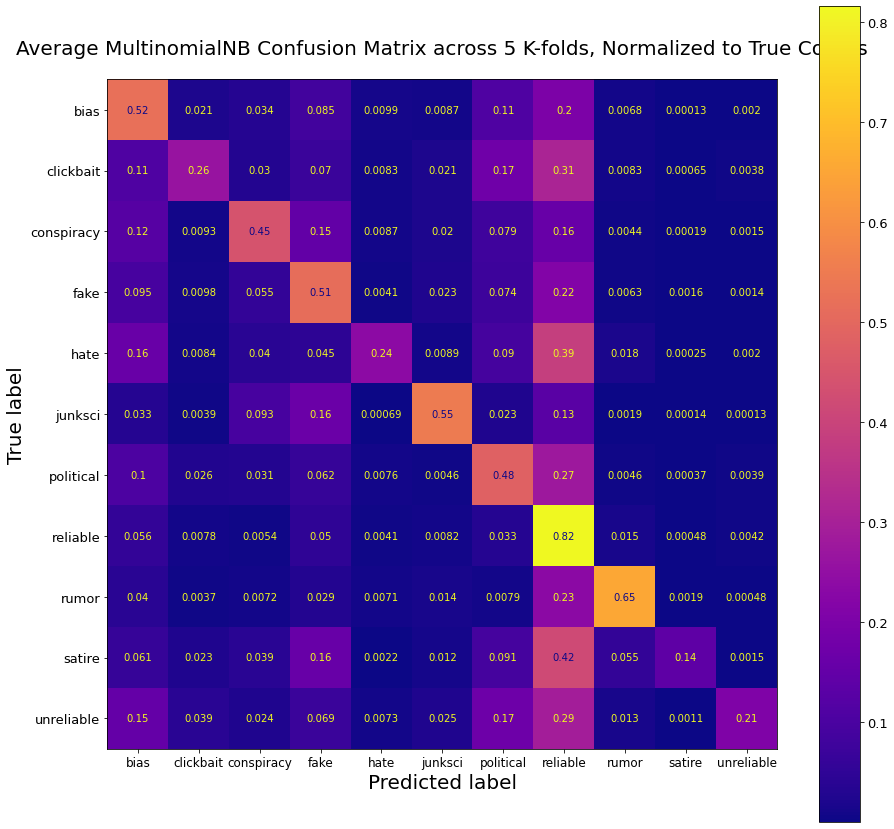

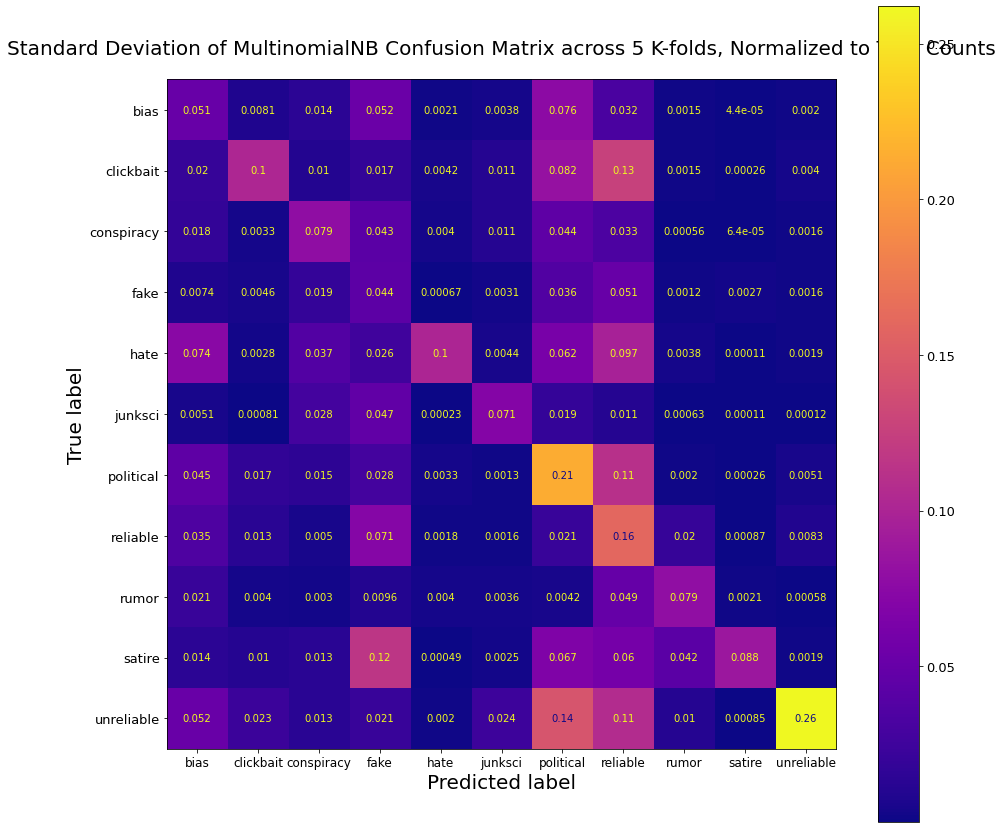

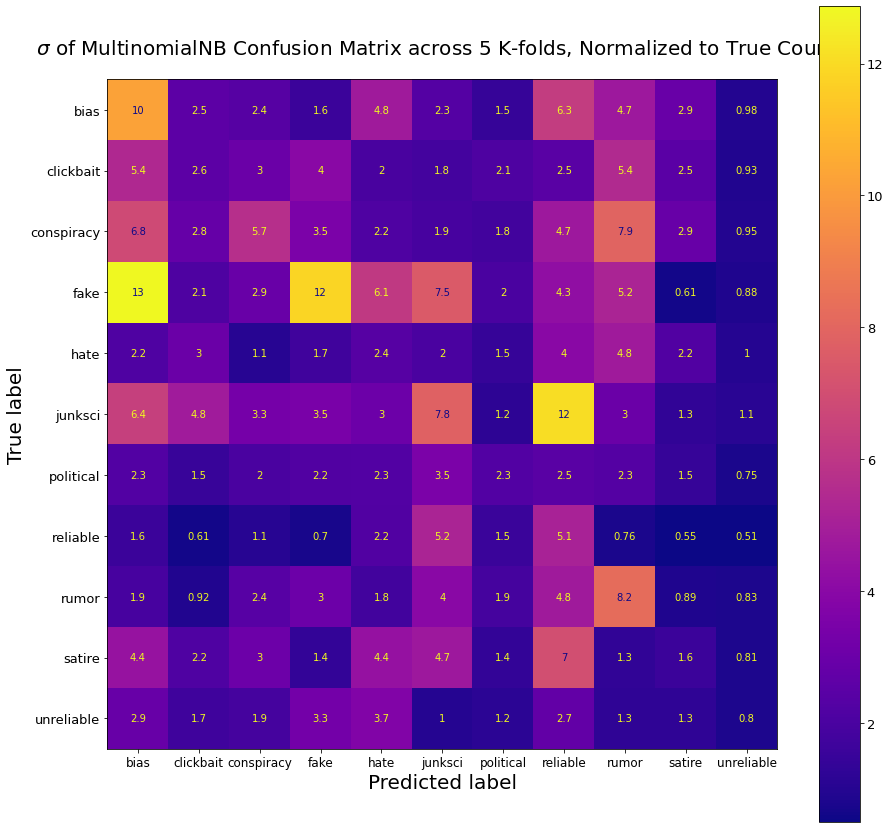

In [20]:
# # Display classification report (for last single classifier)
# print(metrics.classification_report(Test_Y, predictions_NB, target_names=le.classes_))

# Try to model classification report but with stats from K-Fold cross-validation
print(f"Summary MultinomialNB Classification Report of {sets} K-Folds")
print(f"{' ':12}  {'precision':>12}  {'recall':>12}  {'f1-score':>12}  {'support':>14}")

# Get averages and standard deviations for labels
label_avgprecision = np.average(label_precisions, axis=0)
label_avgrecall = np.average(label_recalls, axis=0)
label_avgf1 = np.average(label_f1s, axis=0)
label_avgsupport = np.average(label_support, axis=0)
label_stdprecision = np.std(label_precisions, axis=0)
label_stdrecall = np.std(label_recalls, axis=0)
label_stdf1 = np.std(label_f1s, axis=0)
label_stdsupport = np.std(label_support, axis=0)
total_support = np.sum(label_support,axis=1)
for i, label in enumerate(labels):
    precision_str = f"{label_avgprecision[i]:04.3f}({label_stdprecision[i]:04.3f})"
    recall_str = f"{label_avgrecall[i]:04.3f}({label_stdrecall[i]:04.3f})"
    f1_str = f"{label_avgf1[i]:04.3f}({label_stdf1[i]:04.3f})"
    support_str = f"{label_avgsupport[i]:6.1f}({label_stdsupport[i]:.1f})"
    print(f"{label:12}  {precision_str:12}  {recall_str:12}  {f1_str:12}  {support_str:>14}")
print("")

# Get global averages and standard deviations
avg_totsupport = np.average(total_support, axis=0)
std_totsupport = np.std(total_support, axis=0)
avg_accuracy = np.average(accuracies, axis=0)
std_accuracy = np.std(accuracies, axis=0)
avg_macrorecall = np.average(recalls, axis=0)
std_macrorecall = np.std(recalls, axis=0)
avg_macroprec = np.average(precisions, axis=0)
std_macroprec = np.std(precisions, axis=0)
avg_macrof1 = np.average(f1s, axis=0)
std_macrof1 = np.std(f1s, axis=0)

totsupport_str = f"{avg_totsupport:6.1f}({std_totsupport:.1f})"
accuracy_str = f"{avg_accuracy:04.3f}({std_accuracy:04.3f})"
macro_recall_str = f"{avg_macrorecall:04.3f}({std_macrorecall:04.3f})"
macro_prec_str = f"{avg_macroprec:04.3f}({std_macroprec:04.3f})"
macro_f1_str = f"{avg_macrof1:04.3f}({std_macrof1:04.3f})"

print(f"{'accuracy':12}  {' ':12}  {' ':12}  {accuracy_str:12}  {totsupport_str:>14}")
print(f"{'macro':12}  {macro_prec_str:12}  {macro_recall_str:12}  {macro_f1_str:12}  {totsupport_str:>14}")

# Adjust font sizes (copied from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
size=20
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.60,
          'ytick.labelsize': size*0.65,
          'axes.titlepad': 25}
plt.rcParams.update(params)

# Display average confusion matrix
avg_conf_matrix = np.average(conf_matrices,axis=0)
std_conf_matrix = np.std(conf_matrices,axis=0)
sigma_conf_matrix = avg_conf_matrix/std_conf_matrix  # Computes sigma of how certain average (how different from zero)

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(avg_conf_matrix, display_labels=le.classes_)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"Average MultinomialNB Confusion Matrix across {sets} K-folds, Normalized to True Counts")
plt.savefig("MulticlassMultinomialNBConfusionMatrix_average.png", facecolor="w")  # Save PNG with white background

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(std_conf_matrix, display_labels=le.classes_)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"Standard Deviation of MultinomialNB Confusion Matrix across {sets} K-folds, Normalized to True Counts")
plt.savefig("MulticlassMultinomialNBConfusionMatrix_stdev.png", facecolor="w")

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(sigma_conf_matrix, display_labels=le.classes_)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"$\sigma$ of MultinomialNB Confusion Matrix across {sets} K-folds, Normalized to True Counts")
plt.savefig("MulticlassMultinomialNBConfusionMatrix_sigma.png", facecolor="w")

# Implementation of Testbed Naïve Bayes Classifier (Multiclassifier ComplementNB Version)

Implemented the same multiclass classifier we just did, but as using `ComplementNB()` to perform the ML (it is designed for unbalanced datasets).

In [21]:
# This sets up the Multinomial Naive Bayes classifier, but trained to identify
# from all the classes at once instead of training on single classes (since it
# is possible single 'negative' cases which are a mix of known other classes
# could present a problem to the classifier).

# Nnumber of datasets to make up
sets = 5
n_cat = len(categories)  # Number of categories

# Create arrays to store all metrics data
conf_matrices2 = np.empty((sets, n_cat, n_cat))
accuracies2 = np.empty((sets))
recalls2 = np.empty((sets))
precisions2 = np.empty((sets))
f1s2 = np.empty((sets))
label_precisions2 = np.empty((sets, n_cat))
label_recalls2 = np.empty((sets, n_cat))
label_support2 = np.empty((sets, n_cat))
label_f1s2 = np.empty((sets, n_cat))  #  Must use beta=1 to weight precision and recall equally to get f1

# Set up path to pickle file
multiclassclf_pickle_file = f"{var_dir}MulticlassComplementNB.p"
multiclassclf_pickle_path = pathlib.Path(multiclassclf_pickle_file)
multiclassstats_pickle_file = f"{var_dir}MulticlassComplementNB_stats.p"
multiclassstats_pickle_path = pathlib.Path(multiclassstats_pickle_file)

# If pickle file exists, avoid reprocessing and just load them
if (multiclassclf_pickle_path.is_file() & multiclassstats_pickle_path.is_file() ):
    print(f"Loading previously-built Multiclass MultinomialNB classifier network (about {clfnet_pickle_path.stat().st_size/1024**2:0.2f} MB)")
    clf = pickle.load( open( multiclassclf_pickle_path, "rb" ) )
    [conf_matrices2, accuracies2, recalls2, precisions2, f1s2, label_precisions2, label_recalls2, label_f1s2, label_support2] = pickle.load( open( multiclassstats_pickle_path, "rb" ) )
else:
    # Track time for building of all the classifiers
    network_start_time = time.perf_counter()
    print(f"Constructing ComplementNB multiclass classifier: ")

    # Create blank dictionary
    this_entry = {}

    # Turn classes into numerical labels (trying to see if this 'fixes' problem with confusion matrix dumping
    # out as single row)
    le = LabelEncoder()
    le.fit(categories)
    labels = le.classes_
    labeled_data = le.transform(fullcontext_df['1st_type'])

    # The scikit-learn documentation notes that "Some classification problems can exhibit a large imbalance in
    # the distribution of the target classes: for instance there could be several times more negative samples
    # than positive samples. In such cases it is recommended to use stratified sampling".  This would be useful
    # if I was checking multiple classes, not useful for Naïve Bayes.  Keeping this here as notes in case someone
    # is grabbing testing/training data for multi-class classifier.

    # Create 5 statified datasets for K-fold cross-validation
    # Use the tokenized content so we can avoid having to re-tokenize the data each new pass through.
    print(f" - Executing StratifiedKFold to create {sets} testing/training datasets ... ", end="")
    spliter = model_selection.StratifiedKFold(n_splits=sets)
    print(f"DONE!")
    for fold, (train_index, test_index) in enumerate(spliter.split(tokenized_content, labeled_data)):
        print(f"   - Starting on fold {fold+1} of {sets}.")
        strat_train_set = fullcontext_df.loc[train_index]
        strat_test_set = fullcontext_df.loc[test_index]
        Train_X_Tfidf, Test_X_Tfidf = tokenized_content[train_index], tokenized_content[test_index]
        Train_Y, Test_Y = labeled_data[train_index], labeled_data[test_index]

        # Train this classifier
        start_time = time.perf_counter()
        clf = naive_bayes.ComplementNB()
        clf.fit(Train_X_Tfidf, Train_Y)

        # predict the labels on validation dataset
        predictions_NB = clf.predict(Test_X_Tfidf)
        end_time = time.perf_counter()
        print(f"   - {end_time - start_time:0.2f} seconds to fit and test multiclass ComplementNB classifier on fold {fold+1} of {sets}.")

        # Track the various metrices for each fold
        start_time = time.perf_counter()
        numlabels = [item for item in range(le.classes_.shape[0])]
        conf_matrices2[fold] = metrics.confusion_matrix(Test_Y, predictions_NB, labels=numlabels, normalize='true').ravel().reshape((le.classes_.shape[0], le.classes_.shape[0]))
        # Statistics per label
        label_precisions2[fold], label_recalls2[fold], label_f1s2[fold], label_support2[fold] = metrics.precision_recall_fscore_support(Test_Y, predictions_NB, labels=numlabels, beta=1.0)
        # Macro average means "Calculate metrics for each label, and find their unweighted mean.
        # This does not take label imbalance into account."
        accuracies2[fold] = metrics.accuracy_score(Test_Y, predictions_NB)
        recalls2[fold] = metrics.recall_score(Test_Y, predictions_NB, average='macro')
        precisions2[fold] = metrics.precision_score(Test_Y, predictions_NB, average='macro')
        f1s2[fold] = metrics.f1_score(Test_Y, predictions_NB, average='macro')
        stats = [conf_matrices2, accuracies2, recalls2, precisions2, f1s2, labels, label_precisions2, label_recalls2, label_f1s2, label_support2]
        end_time = time.perf_counter()
        print(f"   - {end_time - start_time:0.2f} seconds to gather metrics on fold {fold+1} of {sets}.")

    print(f"Creating {multiclassclf_pickle_file} ... ")
    pickle.dump(clf, open(multiclassclf_pickle_file, "wb" ) )
    print(f"Creating {multiclassstats_pickle_file} ... ")
    pickle.dump(stats, open(multiclassstats_pickle_file, "wb" ) )

Constructing ComplementNB multiclass classifier: 
 - Executing StratifiedKFold to create 5 testing/training datasets ... DONE!
   - Starting on fold 1 of 5.
   - 6.37 seconds to fit and test multiclass ComplementNB classifier on fold 1 of 5.
   - 2.39 seconds to gather metrics on fold 1 of 5.
   - Starting on fold 2 of 5.
   - 6.43 seconds to fit and test multiclass ComplementNB classifier on fold 2 of 5.
   - 1.95 seconds to gather metrics on fold 2 of 5.
   - Starting on fold 3 of 5.
   - 6.85 seconds to fit and test multiclass ComplementNB classifier on fold 3 of 5.
   - 1.99 seconds to gather metrics on fold 3 of 5.
   - Starting on fold 4 of 5.
   - 6.24 seconds to fit and test multiclass ComplementNB classifier on fold 4 of 5.
   - 1.84 seconds to gather metrics on fold 4 of 5.
   - Starting on fold 5 of 5.
   - 6.76 seconds to fit and test multiclass ComplementNB classifier on fold 5 of 5.
   - 1.94 seconds to gather metrics on fold 5 of 5.
Creating ../Variables/MulticlassComple

Summary ComplementNB Classification Report of 5 K-Folds
                 precision        recall      f1-score         support
bias          0.510(0.065)  0.527(0.049)  0.517(0.053)   218306.6(0.5)
clickbait     0.476(0.218)  0.211(0.093)  0.289(0.125)    47335.4(0.5)
conspiracy    0.574(0.079)  0.468(0.079)  0.514(0.076)   166982.8(0.4)
fake          0.531(0.059)  0.494(0.027)  0.510(0.033)   175606.6(0.5)
hate          0.494(0.140)  0.180(0.078)  0.262(0.103)    25602.0(0.0)
junksci       0.425(0.045)  0.574(0.082)  0.487(0.054)    28509.2(0.4)
political     0.649(0.027)  0.485(0.188)  0.537(0.124)   330868.8(0.4)
reliable      0.556(0.065)  0.829(0.123)  0.662(0.075)   377892.4(0.5)
rumor         0.650(0.065)  0.700(0.053)  0.672(0.048)    95990.6(0.5)
satire        0.589(0.262)  0.189(0.133)  0.275(0.177)    22304.2(0.4)
unreliable    0.460(0.183)  0.217(0.245)  0.269(0.241)    48061.0(0.0)

accuracy                                  0.564(0.050)  1537459.6(0.5)
macro         0.538(

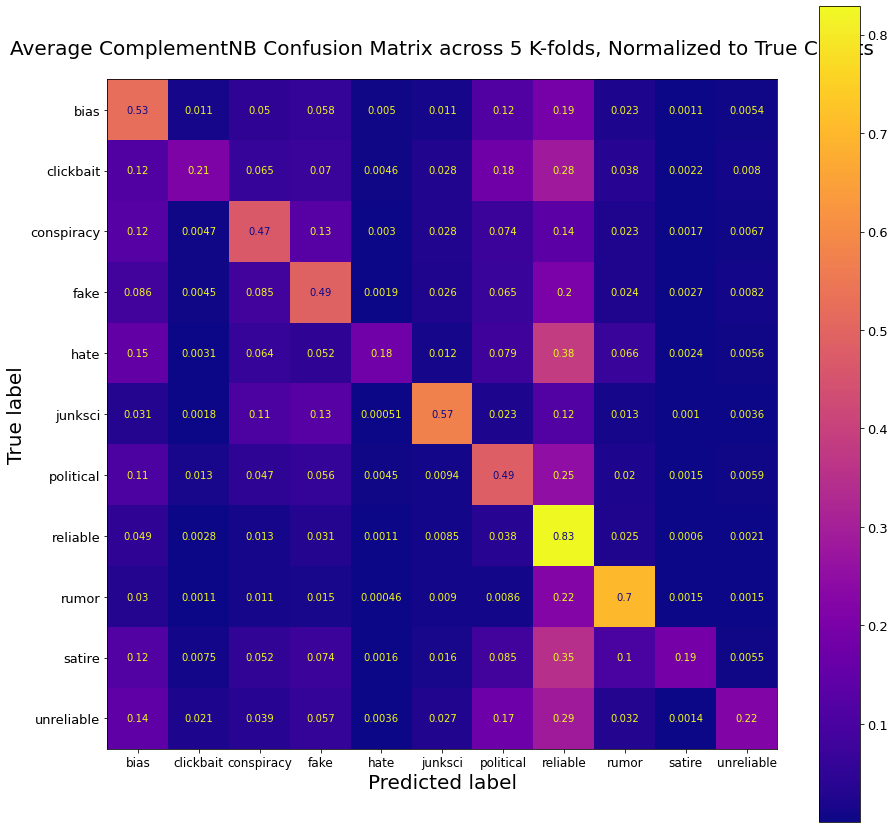

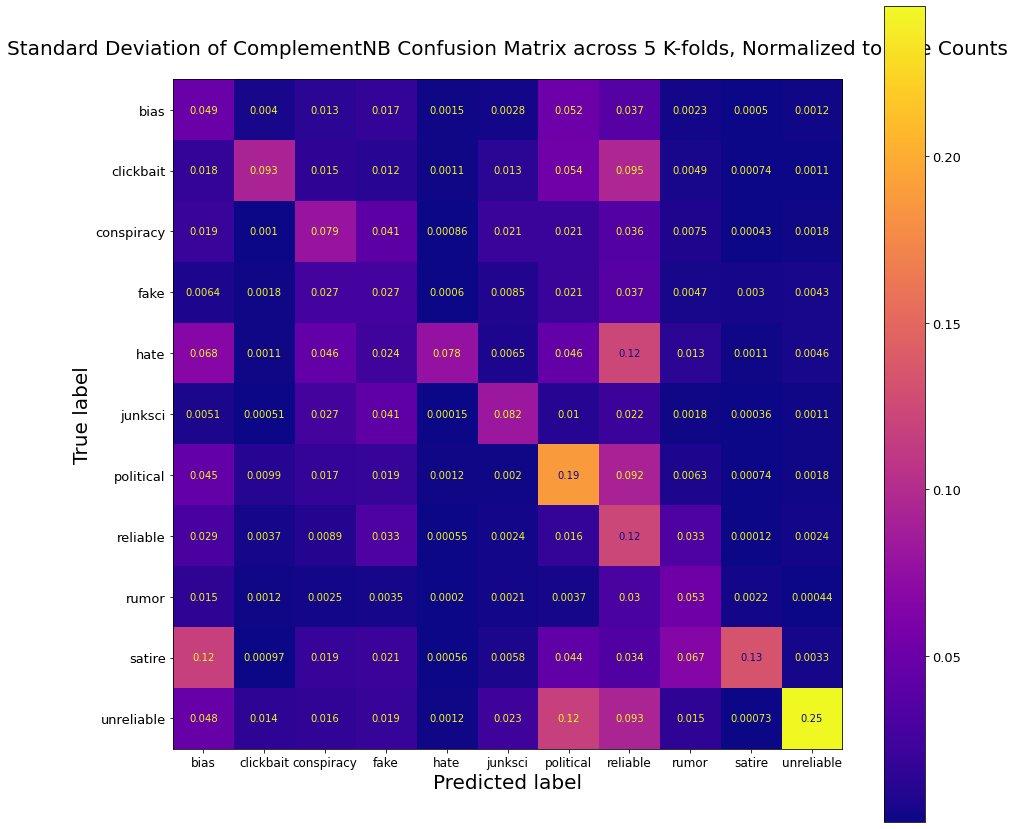

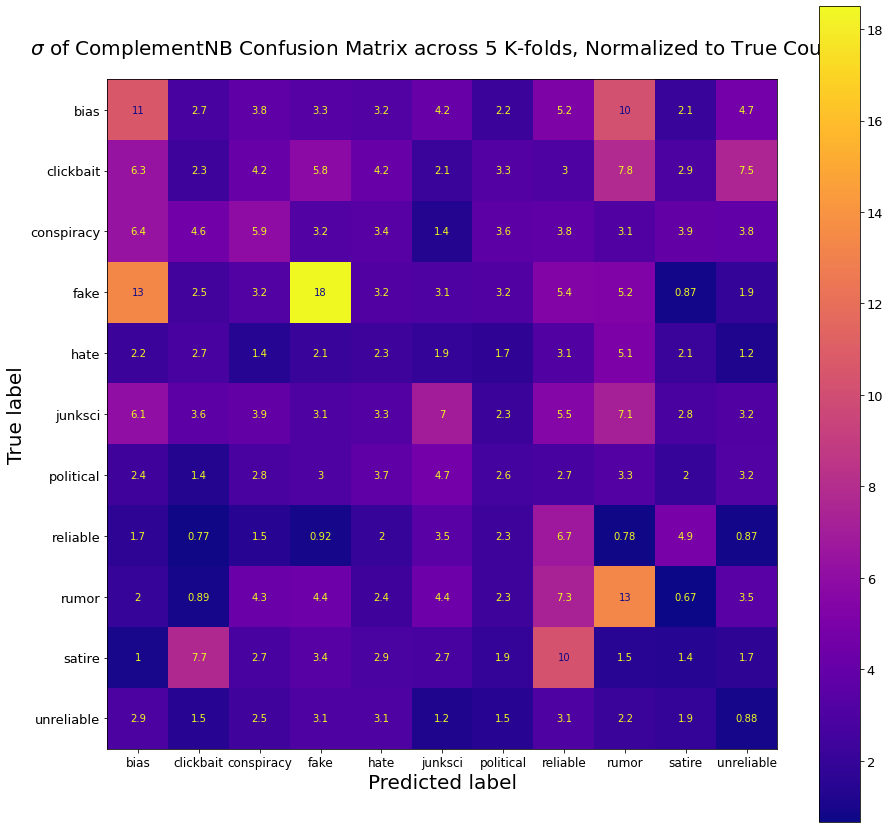

In [22]:
# # Display classification report (for last single classifier)
# print(metrics.classification_report(Test_Y, predictions_NB, target_names=le.classes_))

# Try to model classification report but with stats from K-Fold cross-validation
print(f"Summary ComplementNB Classification Report of {sets} K-Folds")
print(f"{' ':12}  {'precision':>12}  {'recall':>12}  {'f1-score':>12}  {'support':>14}")

# Get averages and standard deviations for labels
label_avgprecision2 = np.average(label_precisions2, axis=0)
label_avgrecall2 = np.average(label_recalls2, axis=0)
label_avgf12 = np.average(label_f1s2, axis=0)
label_avgsupport2 = np.average(label_support2, axis=0)
label_stdprecision2 = np.std(label_precisions2, axis=0)
label_stdrecall2 = np.std(label_recalls2, axis=0)
label_stdf12 = np.std(label_f1s2, axis=0)
label_stdsupport2 = np.std(label_support2, axis=0)
total_support2 = np.sum(label_support2,axis=1)
for i, label in enumerate(labels):
    precision_str = f"{label_avgprecision2[i]:04.3f}({label_stdprecision2[i]:04.3f})"
    recall_str = f"{label_avgrecall2[i]:04.3f}({label_stdrecall2[i]:04.3f})"
    f1_str = f"{label_avgf12[i]:04.3f}({label_stdf12[i]:04.3f})"
    support_str = f"{label_avgsupport2[i]:6.1f}({label_stdsupport2[i]:.1f})"
    print(f"{label:12}  {precision_str:12}  {recall_str:12}  {f1_str:12}  {support_str:>14}")
print("")

# Get global averages and standard deviations
avg_totsupport2 = np.average(total_support2, axis=0)
std_totsupport2 = np.std(total_support2, axis=0)
avg_accuracy2 = np.average(accuracies2, axis=0)
std_accuracy2 = np.std(accuracies2, axis=0)
avg_macrorecall2 = np.average(recalls2, axis=0)
std_macrorecall2 = np.std(recalls2, axis=0)
avg_macroprec2 = np.average(precisions2, axis=0)
std_macroprec2 = np.std(precisions2, axis=0)
avg_macrof12 = np.average(f1s2, axis=0)
std_macrof12 = np.std(f1s2, axis=0)

totsupport_str = f"{avg_totsupport2:6.1f}({std_totsupport2:.1f})"
accuracy_str = f"{avg_accuracy2:04.3f}({std_accuracy2:04.3f})"
macro_recall_str = f"{avg_macrorecall2:04.3f}({std_macrorecall2:04.3f})"
macro_prec_str = f"{avg_macroprec2:04.3f}({std_macroprec2:04.3f})"
macro_f1_str = f"{avg_macrof12:04.3f}({std_macrof12:04.3f})"

print(f"{'accuracy':12}  {' ':12}  {' ':12}  {accuracy_str:12}  {totsupport_str:>14}")
print(f"{'macro':12}  {macro_prec_str:12}  {macro_recall_str:12}  {macro_f1_str:12}  {totsupport_str:>14}")

# Adjust font sizes (copied from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
size=20
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.60,
          'ytick.labelsize': size*0.65,
          'axes.titlepad': 25}
plt.rcParams.update(params)

# Display average confusion matrix
avg_conf_matrix2 = np.average(conf_matrices2,axis=0)
std_conf_matrix2 = np.std(conf_matrices2,axis=0)
sigma_conf_matrix2 = avg_conf_matrix2/std_conf_matrix2  # Computes sigma of how certain average (how different from zero)

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(avg_conf_matrix2, display_labels=le.classes_)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"Average ComplementNB Confusion Matrix across {sets} K-folds, Normalized to True Counts")
plt.savefig("MulticlassComplementNBConfusionMatrix_average.png", facecolor="w")  # Save PNG with white background

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(std_conf_matrix2, display_labels=le.classes_)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"Standard Deviation of ComplementNB Confusion Matrix across {sets} K-folds, Normalized to True Counts")
plt.savefig("MulticlassComplementNBConfusionMatrix_stdev.png", facecolor="w")

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(sigma_conf_matrix2, display_labels=le.classes_)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"$\sigma$ of ComplementNB Confusion Matrix across {sets} K-folds, Normalized to True Counts")
plt.savefig("MulticlassComplementNBConfusionMatrix_sigma.png", facecolor="w")

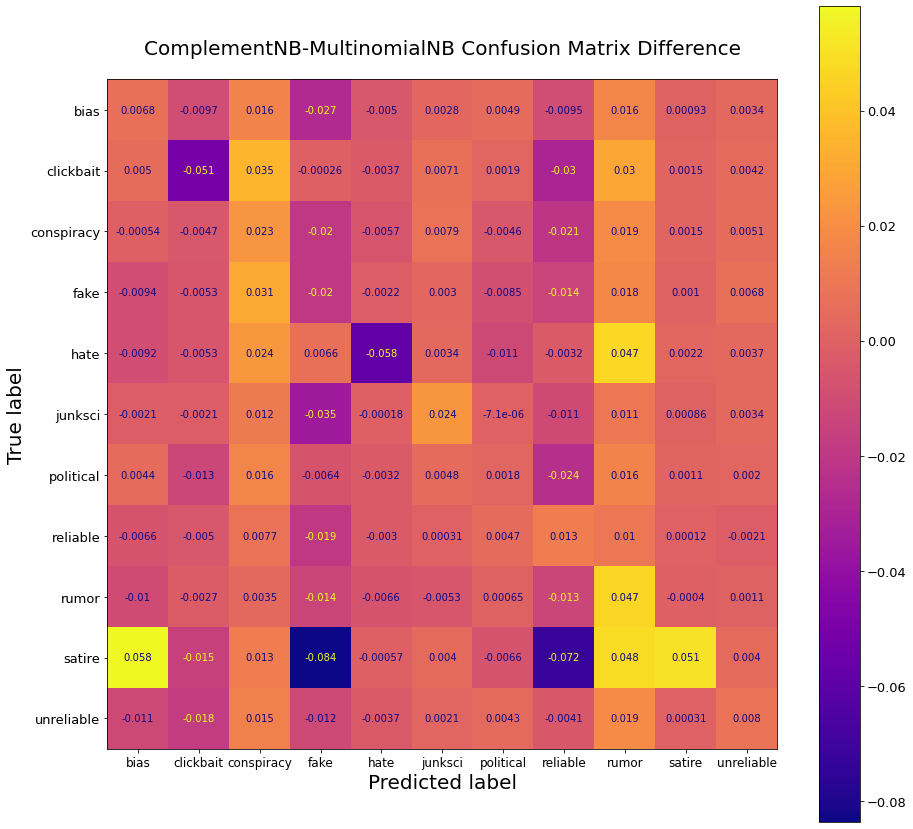

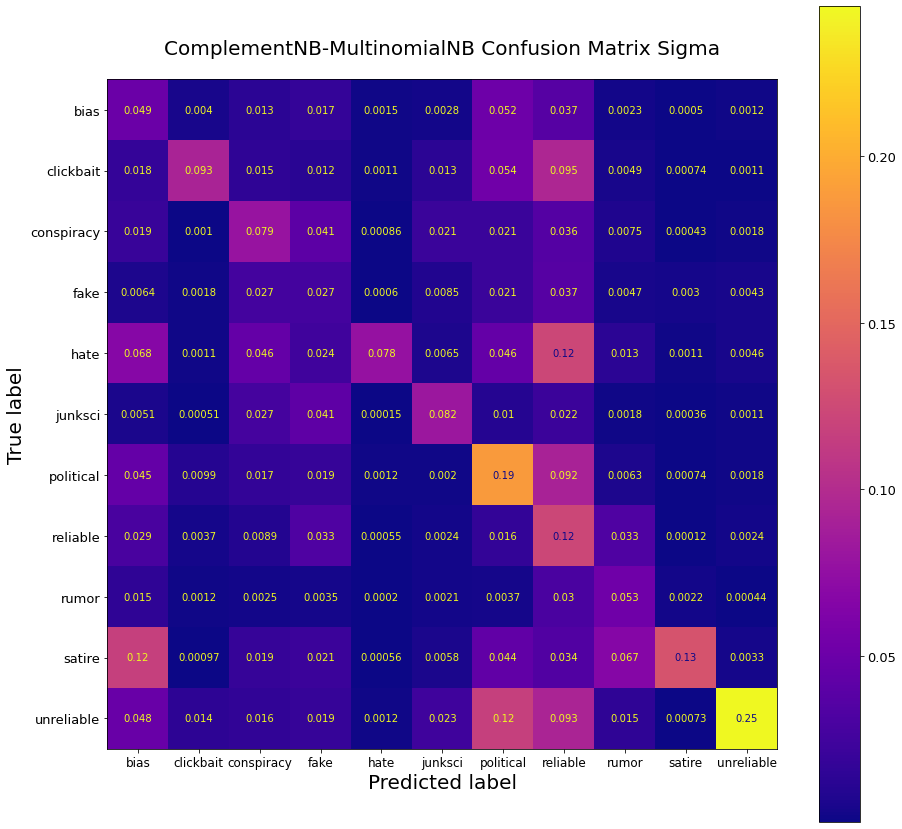

In [23]:
# Consider comparing the two confusion matrices directly (do they statistically differ?)

difference = avg_conf_matrix2 - avg_conf_matrix
sig_difference = (avg_conf_matrix2 - avg_conf_matrix)/(std_conf_matrix2+std_conf_matrix)

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(difference, display_labels=le.classes_)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"ComplementNB-MultinomialNB Confusion Matrix Difference")
plt.savefig("MulticlassConfusionMatrix_difference.png", facecolor="w")  # Save PNG with white background

fig, ax = plt.subplots(figsize=(15, 15))
disp = metrics.ConfusionMatrixDisplay(std_conf_matrix2, display_labels=le.classes_)
disp.plot(cmap='plasma', ax=ax)
disp.ax_.set_title(f"ComplementNB-MultinomialNB Confusion Matrix Sigma")
plt.savefig("MulticlassConfusionMatrix_differencesigma.png", facecolor="w")
